In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model
import os
from google.colab import drive
import zipfile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import csv
import time

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
  from thop import profile, clever_format
except:
    print("[INFO] Couldn't find thop... installing it.")
    !pip install thop
    from thop import profile, clever_format

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find thop... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"[INFO] Using {torch.cuda.get_device_name(0)}")
else:
    print("[INFO] Using CPU")

[INFO] Using Tesla V100-SXM2-16GB


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation'
file_dir = '/content/evaluation'

#Upload train data folder to google colab files directory
if not os.path.exists(file_dir):
  os.makedirs(file_dir)
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'train_single.zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [6]:
class_dict = {0 : "safe driving",
              1 : "drinking",
              2 : "talking on the phone - left",
              3 : "talking on the phone - right",
              4 : "texting - left",
              5 : "texting - right",
              6 : "Doing hair",
              7 : "Adjusting specs",
              8 : "Reaching behind",
              9 : "Sleeping"}

In [7]:
data_path = "/content/evaluation/train_single/side_RGB"
classes = [c for c in os.listdir(data_path) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
print(classes)

FileNotFoundError: [Errno 2] No such file or directory: '/content/evaluation/train_single/side_RGB'

Total number of  data : 5000
{'0': 500, '1': 500, '2': 500, '3': 500, '4': 500, '5': 500, '6': 500, '7': 500, '8': 500, '9': 500}


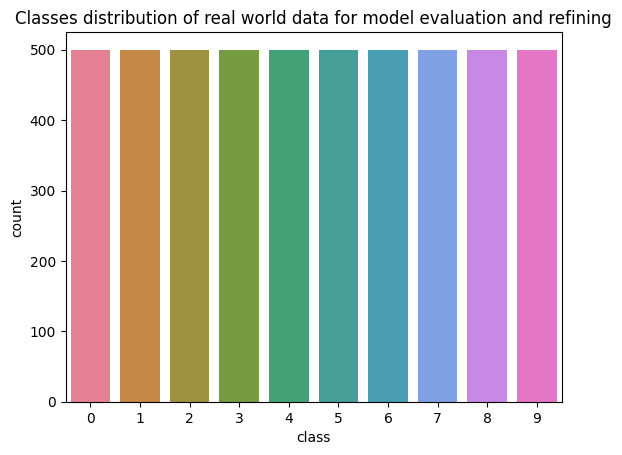

In [20]:
d = {"img" : [], "class" : []}
data_count = {}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(data_path,c)) if not img.startswith(".")]
    data_count[c] = len(imgs)
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of real world data for model evaluation and refining")
print("Total number of  data :",len(df))
print(data_count)

In [21]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

data = datasets.ImageFolder(root = data_path, transform = transform)

5000


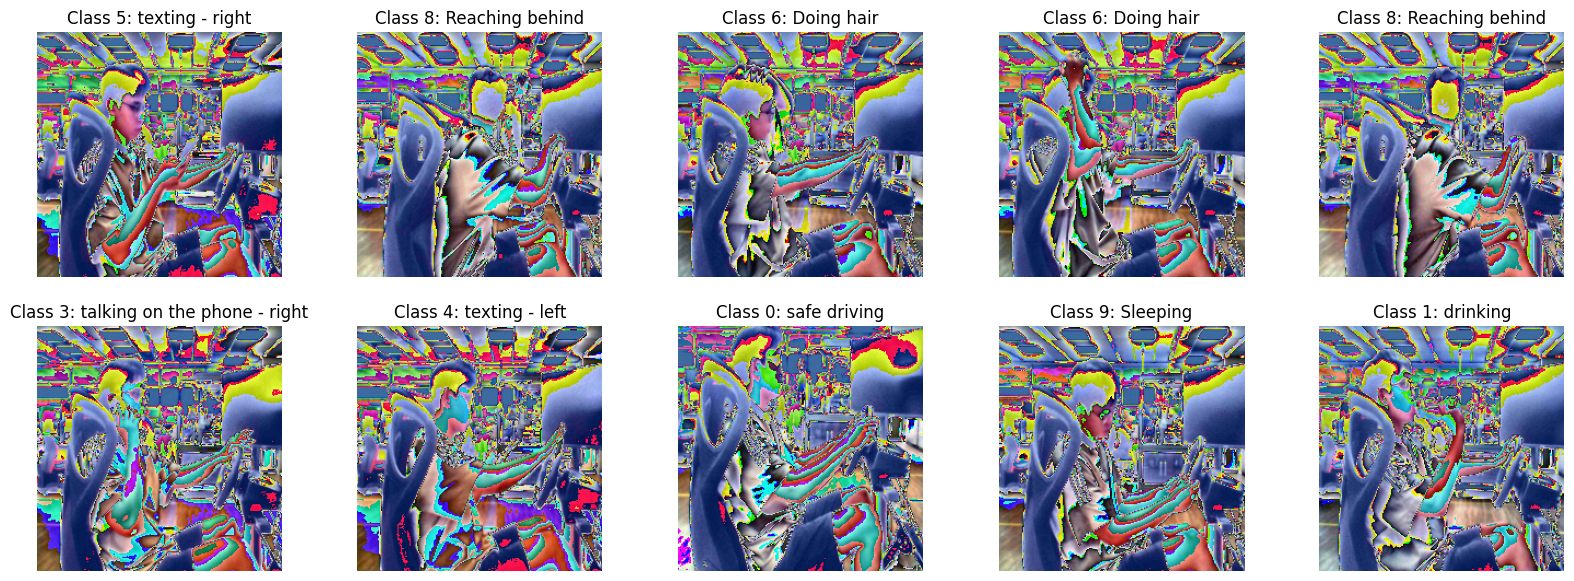

In [22]:
total_data = len(data)
print(total_data)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_data)
  image, label = data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

In [23]:
batch_size = 16
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)

In [24]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_feature = model.classifier[0].in_features
output_shape = num_classes

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_feature, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_shape)
)

In [25]:
log_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3_side'

checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [26]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [27]:
input, label = next(iter(data_loader))
input = input.to(device)
flops, params = profile(model, inputs=(input, ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


In [49]:
# Base directories for saving images
correct_dir = os.path.join(folder_path, "side_classified_images/correct")
misclassified_dir = os.path.join(folder_path, "side_classified_images/misclassified")
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(misclassified_dir, exist_ok=True)

In [29]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in data_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())
        images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    idx = np.random.randint(0, len(all_preds_np))
    image = images_to_display[idx].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[idx]]}\nPred: {class_dict[all_preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:

# Initialize a counter for misclassified images
num_misclassified = 0

# Calculate the number of misclassified images
for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

print(f"Number of misclassified images: {num_misclassified}")



Number of misclassified images: 4246


In [50]:
for i, (image_np, pred, true_label) in enumerate(zip(images_to_display, all_preds, all_true_labels)):
    image = image_np.transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    image_pil = Image.fromarray(image)

    # Determine if the classification is correct
    is_correct = (pred == true_label)
    save_path = correct_dir if is_correct else misclassified_dir

    # Define the directory based on the true label
    label_dir = os.path.join(save_path, str(true_label))
    os.makedirs(label_dir, exist_ok=True)

    # Save the image
    image_file = os.path.join(label_dir, f"image_actual{true_label}_pred{pred}_{i}.jpg")
    image_pil.save(image_file)

In [34]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

save_path = os.path.join(folder_path, 'side_unrefined_performance')
os.makedirs(save_path, exist_ok=True)

result_path = os.path.join(save_path, 'model_predictions.csv')
metrics_path = os.path.join(save_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

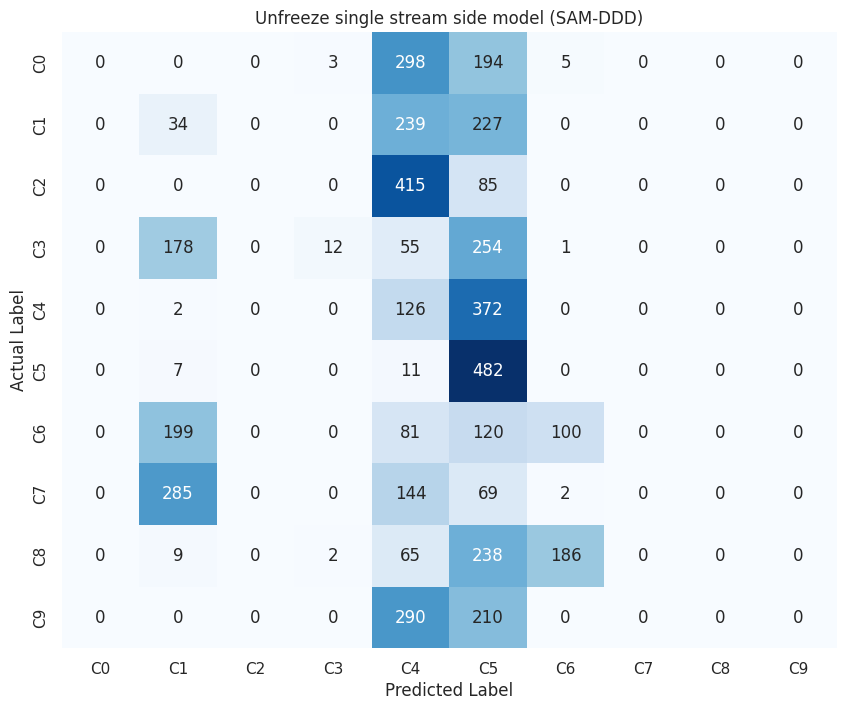

In [35]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Unfreeze single stream side model (SAM-DDD)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [54]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_features = model.classifier[0].in_features
output_class = 10

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_class))

log_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/training_log/mobilenetv3_side'

checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

pretrained_features = model.features.to(device)

model.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [55]:
for param in model.features.parameters():
    param.requires_grad = False

model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [39]:
summary(model=model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 

In [47]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [51]:
misclassified_dir = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/side_classified_images/misclassified'
correct_dir = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/side_classified_images/correct'
misclassified_data = CustomDataset(root_dir = misclassified_dir)
correct_data = datasets.ImageFolder(root= correct_dir)
dataset = ConcatDataset([correct_data, misclassified_data])

In [52]:
torch.manual_seed(42)

valid_size = int(0.2*len(dataset))
train_size = len(dataset)-valid_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])
len(dataset), len(train_data), len(valid_data)

(5000, 4000, 1000)

In [53]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
rotation = transforms.RandomRotation(15)
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
translation = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))

train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([translation], p=0.5),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

valid_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

In [56]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [57]:
train_data = TransformDataset(train_data, transform=train_transform)
valid_data = TransformDataset(valid_data, transform=valid_transform)

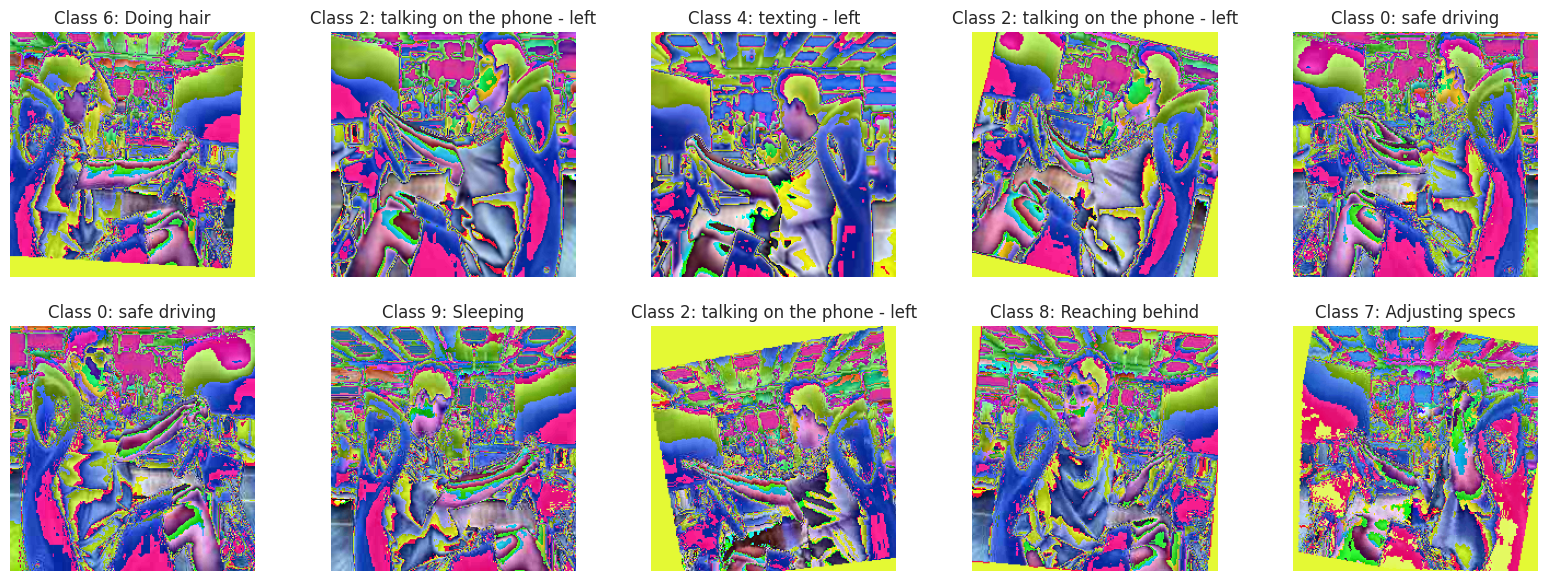

In [58]:
total_train_data = len(train_data)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_train_data)
  image, label = train_data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

In [59]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [60]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [61]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.01, threshold_mode='rel')

In [63]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [64]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

In [65]:
early_stopping = EarlyStopping(patience=10, min_delta=0.005)

In [66]:
class CSVLogger:
    def __init__(self, filename, fieldnames=['epoch','learning_rate', 'epoch_duration', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc']):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create file and write header
        with open(self.filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc):
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow({
                'epoch': epoch,
                'learning_rate': lr,
                'epoch_duration': epoch_duration,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'valid_loss': valid_loss,
                'valid_acc': valid_acc
            })

In [67]:
log_path = os.path.join(folder_path,'training_log/side_refined_all')
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [68]:
logger = CSVLogger(os.path.join(log_path,'training_log.csv'))

In [69]:
cp_filename = os.path.join(log_path,'my_checkpoint.pth.tar')

def save_checkpoint(state, filename=cp_filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [70]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_acc = 0
    min_lr = 1e-7
    # Start the timer
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      #------- Training----------
      train_loss, train_acc = 0, 0

      model.train()
      for batch, (X_train, y_train) in enumerate(train_loader):
        model.train()
        # 1. Forward pass
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()  # Reset gradients at the start of each epoch


        train_pred = model(X_train)
        loss = criterion(train_pred, y_train)
        train_loss +=loss

        # 4. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))
        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X_train)}/{len(train_loader.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_loader)

      epoch_duration = time.time()-since
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      valid_loss = 0
      valid_acc = 0
      model.eval()
      with torch.inference_mode():
        for X_valid, y_valid in valid_loader:
          # 1. Forward pass
          X_valid = X_valid.to(device)
          y_valid = y_valid.to(device)
          valid_pred = model(X_valid)

          valid_loss += criterion(valid_pred, y_valid)

          # 3. Calculate accuracy (preds need to be same as y_true)
          valid_acc += accuracy_fn(y_true=y_valid, y_pred=valid_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

      # Model Checkpointing
      if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

      for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(lr)

      scheduler.step(valid_acc)
      for param_group in optimizer.param_groups:
          param_group['lr'] = max(param_group['lr'], min_lr)

      ## Print out what's happening
      print(f"\nEpoch duration: {epoch_duration:.0f}s, lr: {lr}, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Valid loss: {valid_loss:.2f}, Valid acc: {valid_acc:.2f}%\n")

      logger.log(epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc)


      early_stopping(valid_acc)
      if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("Finished Training")
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f}")
    return model, train_losses, train_accuracies,valid_losses, valid_accuracies



In [71]:
model, train_losses, training_accs, valid_losses, valid_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples
=> Saving checkpoint
0.0001

Epoch duration: 18s, lr: 0.0001, Train loss: 2.30893, Train acc: 28.90% | Valid loss: 1.31, Valid acc: 53.20%



  1%|          | 1/100 [00:21<36:06, 21.88s/it]


Epoch: 1
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  2%|▏         | 2/100 [00:42<34:31, 21.14s/it]

=> Saving checkpoint
0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 1.49247, Train acc: 49.17% | Valid loss: 0.91, Valid acc: 76.90%


Epoch: 2
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  3%|▎         | 3/100 [01:03<33:50, 20.94s/it]

=> Saving checkpoint
0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 1.23456, Train acc: 60.77% | Valid loss: 0.72, Valid acc: 84.80%


Epoch: 3
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  4%|▍         | 4/100 [01:23<33:19, 20.82s/it]

=> Saving checkpoint
0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 1.07352, Train acc: 66.83% | Valid loss: 0.62, Valid acc: 87.30%


Epoch: 4
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  5%|▌         | 5/100 [01:44<32:59, 20.84s/it]

=> Saving checkpoint
0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 0.97967, Train acc: 70.33% | Valid loss: 0.54, Valid acc: 90.40%


Epoch: 5
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  6%|▌         | 6/100 [02:05<32:31, 20.76s/it]

0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 0.91261, Train acc: 72.95% | Valid loss: 0.48, Valid acc: 90.40%


Epoch: 6
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  7%|▋         | 7/100 [02:26<32:15, 20.82s/it]

=> Saving checkpoint
0.0001

Epoch duration: 18s, lr: 0.0001, Train loss: 0.82518, Train acc: 74.90% | Valid loss: 0.44, Valid acc: 90.80%


Epoch: 7
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  8%|▊         | 8/100 [02:46<31:46, 20.73s/it]

=> Saving checkpoint
0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 0.77159, Train acc: 76.97% | Valid loss: 0.41, Valid acc: 91.70%


Epoch: 8
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


  9%|▉         | 9/100 [03:07<31:28, 20.75s/it]

0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 0.72489, Train acc: 78.90% | Valid loss: 0.39, Valid acc: 91.60%


Epoch: 9
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 10%|█         | 10/100 [03:28<31:15, 20.84s/it]

=> Saving checkpoint
0.0001

Epoch duration: 18s, lr: 0.0001, Train loss: 0.70356, Train acc: 79.45% | Valid loss: 0.36, Valid acc: 92.70%


Epoch: 10
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 11%|█         | 11/100 [03:49<30:57, 20.87s/it]

0.0001

Epoch duration: 18s, lr: 0.0001, Train loss: 0.67810, Train acc: 79.58% | Valid loss: 0.34, Valid acc: 92.30%


Epoch: 11
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 12%|█▏        | 12/100 [04:10<30:35, 20.86s/it]

0.0001

Epoch duration: 17s, lr: 0.0001, Train loss: 0.66094, Train acc: 80.72% | Valid loss: 0.35, Valid acc: 91.90%


Epoch: 12
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 13%|█▎        | 13/100 [04:31<30:17, 20.89s/it]

=> Saving checkpoint
0.0001

Epoch duration: 18s, lr: 0.0001, Train loss: 0.64649, Train acc: 81.58% | Valid loss: 0.31, Valid acc: 92.80%


Epoch: 13
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 14%|█▍        | 14/100 [04:52<30:02, 20.96s/it]

=> Saving checkpoint
5e-05

Epoch duration: 18s, lr: 5e-05, Train loss: 0.60032, Train acc: 82.65% | Valid loss: 0.31, Valid acc: 93.00%


Epoch: 14
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 15%|█▌        | 15/100 [05:13<29:43, 20.98s/it]

5e-05

Epoch duration: 18s, lr: 5e-05, Train loss: 0.59766, Train acc: 82.90% | Valid loss: 0.30, Valid acc: 92.80%


Epoch: 15
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 16%|█▌        | 16/100 [05:34<29:27, 21.05s/it]

5e-05

Epoch duration: 18s, lr: 5e-05, Train loss: 0.60744, Train acc: 81.78% | Valid loss: 0.31, Valid acc: 92.50%


Epoch: 16
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 17%|█▋        | 17/100 [05:55<29:00, 20.97s/it]

2.5e-05

Epoch duration: 17s, lr: 2.5e-05, Train loss: 0.58437, Train acc: 83.97% | Valid loss: 0.30, Valid acc: 92.90%


Epoch: 17
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 18%|█▊        | 18/100 [06:16<28:39, 20.96s/it]

2.5e-05

Epoch duration: 18s, lr: 2.5e-05, Train loss: 0.57531, Train acc: 83.78% | Valid loss: 0.30, Valid acc: 92.80%


Epoch: 18
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 19%|█▉        | 19/100 [06:37<28:23, 21.03s/it]

2.5e-05

Epoch duration: 18s, lr: 2.5e-05, Train loss: 0.60450, Train acc: 82.80% | Valid loss: 0.29, Valid acc: 92.90%


Epoch: 19
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 20%|██        | 20/100 [06:58<27:57, 20.97s/it]

1.25e-05

Epoch duration: 17s, lr: 1.25e-05, Train loss: 0.56033, Train acc: 84.15% | Valid loss: 0.29, Valid acc: 92.80%


Epoch: 20
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 21%|██        | 21/100 [07:19<27:49, 21.13s/it]

1.25e-05

Epoch duration: 18s, lr: 1.25e-05, Train loss: 0.57488, Train acc: 84.35% | Valid loss: 0.29, Valid acc: 92.80%


Epoch: 21
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 22%|██▏       | 22/100 [07:41<27:33, 21.20s/it]

1.25e-05

Epoch duration: 18s, lr: 1.25e-05, Train loss: 0.57466, Train acc: 82.78% | Valid loss: 0.29, Valid acc: 92.90%


Epoch: 22
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 23%|██▎       | 23/100 [08:02<27:09, 21.17s/it]

6.25e-06

Epoch duration: 18s, lr: 6.25e-06, Train loss: 0.57004, Train acc: 83.12% | Valid loss: 0.29, Valid acc: 92.70%


Epoch: 23
-------
Looked at 0/4000 samples
Looked at 400/4000 samples
Looked at 800/4000 samples
Looked at 1200/4000 samples
Looked at 1600/4000 samples
Looked at 2000/4000 samples
Looked at 2400/4000 samples
Looked at 2800/4000 samples
Looked at 3200/4000 samples
Looked at 3600/4000 samples


 23%|██▎       | 23/100 [08:23<28:05, 21.89s/it]

6.25e-06

Epoch duration: 18s, lr: 6.25e-06, Train loss: 0.57220, Train acc: 83.40% | Valid loss: 0.29, Valid acc: 92.90%

Early stopping triggered
Finished Training
Total training time: 503.57


#Loss and Accuracy Plot for refined training on misclassified data


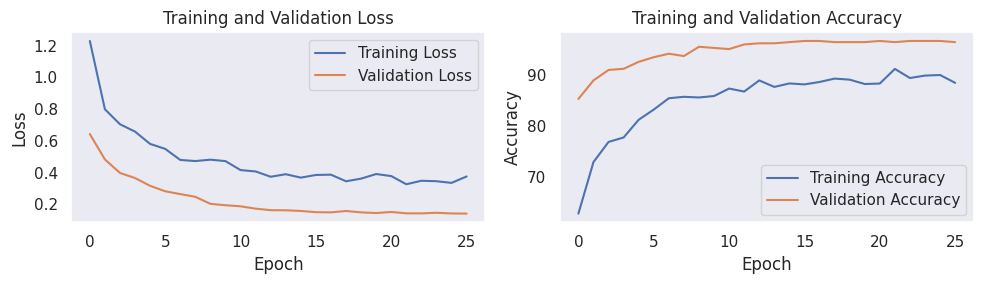

In [ ]:
# training_losses_cpu = [loss.detach().cpu().numpy() for loss in train_losses]
# valid_losses_cpu = [loss.detach().cpu().numpy() for loss in valid_losses]

# fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# axes[0].plot(training_losses_cpu, label="Training Loss")
# axes[0].plot(valid_losses_cpu, label="Validation Loss")
# axes[0].set_title("Training and Validation Loss")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Loss")
# axes[0].legend()
# axes[0].grid(False)

# axes[1].plot(training_accs, label="Training Accuracy")
# axes[1].plot(valid_accs, label="Validation Accuracy")
# axes[1].set_title("Training and Validation Accuracy")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Accuracy")
# axes[1].legend()
# axes[1].grid(False)

# plt.tight_layout()
# plt.show()

#Loss and Accuracy Plot for refined training on real world dataset

In [4]:
folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation'
file_dir = '/content/evaluation'

#Upload train data folder to google colab files directory
if not os.path.exists(os.path.join(file_dir, 'valid_data')):
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'valid_data.zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

Total number of  data : 2000
{'4': 200, '9': 200, '6': 200, '3': 200, '7': 200, '5': 200, '8': 200, '1': 200, '2': 200, '0': 200}


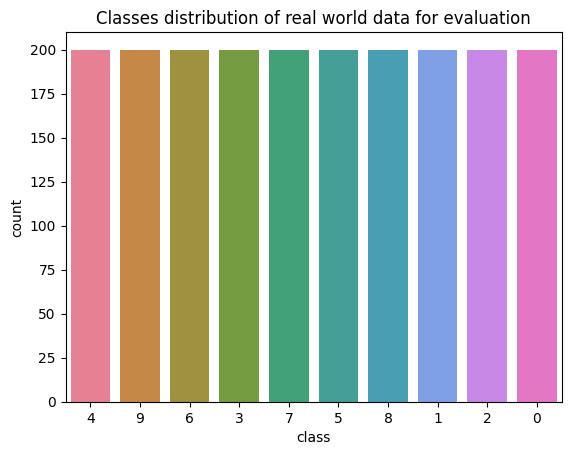

In [9]:
test_path = '/content/evaluation/valid_data/side_RGB'
d = {"img" : [], "class" : []}
data_count = {}
for c in os.listdir(test_path):
    imgs = [img for img in os.listdir(os.path.join(test_path,c)) if not img.startswith(".")]
    data_count[c] = len(imgs)
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of real world data for evaluation")
print("Total number of  data :",len(df))
print(data_count)

In [10]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

test_data = datasets.ImageFolder(root = test_path, transform = transform)

2000


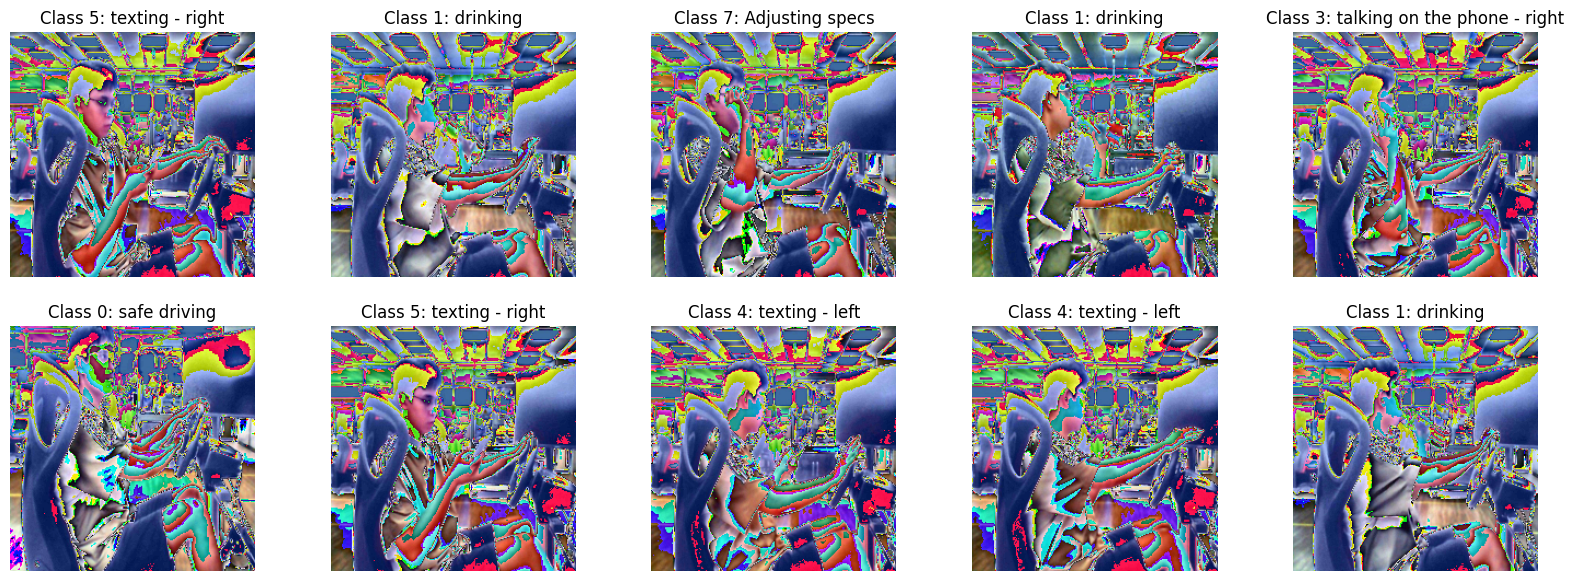

In [11]:
total_data = len(test_data)
print(total_data)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_data)
  image, label = test_data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

In [12]:
batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_features = model.classifier[0].in_features
output_class = 10

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_class))

refine_log_path = os.path.join(folder_path,'training_log/side_refined_all')

checkpoint_path = os.path.join(refine_log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

pretrained_features = model.features.to(device)

model.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
summary(model=model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [15]:
input, label = next(iter(test_loader))
input = input.to(device)
flops, params = profile(model, inputs=(input, ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


In [16]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())
        images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    idx = np.random.randint(0, len(all_preds_np))
    image = images_to_display[idx].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[idx]]}\nPred: {class_dict[all_preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Evaluation on real word validation data after refined on real world data

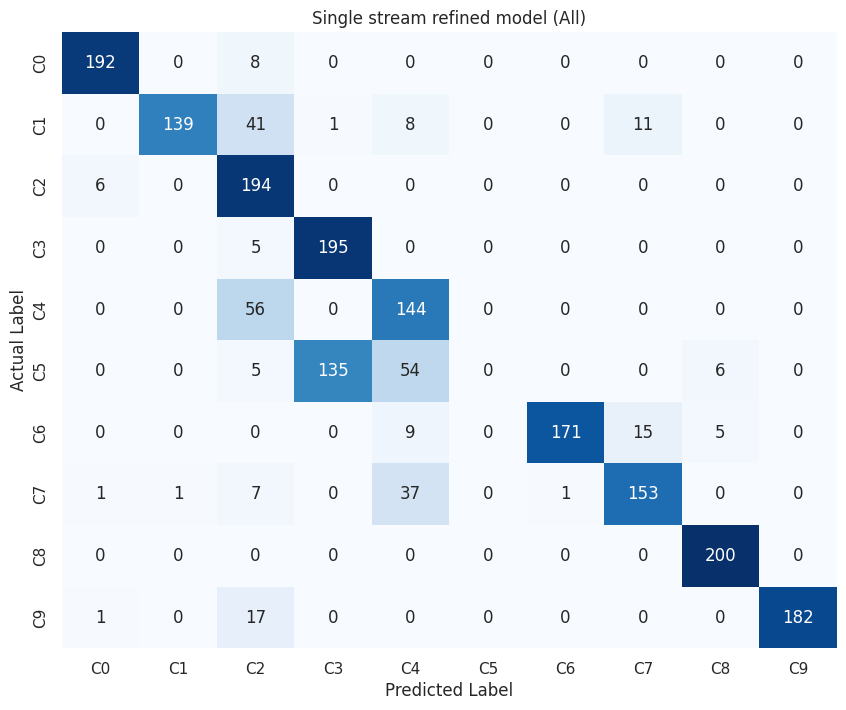

In [17]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Single stream refined model (All)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
# Initialize a counter for misclassified images
num_misclassified = 0

# Calculate the number of misclassified images
for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

print(f"Number of misclassified images: {num_misclassified}")


Number of misclassified images: 430


In [19]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation'

# save_path_misclassified = os.path.join(folder_path, 'unfreeze_single_misclassified')
save_path_all = os.path.join(folder_path, 'side_refined_performance')

os.makedirs(save_path_all, exist_ok=True)

result_path = os.path.join(save_path_all, 'model_predictions.csv')
metrics_path = os.path.join(save_path_all, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [20]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path_all, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)